*Credits: this notebook origin (shared under MIT license) belongs to [ML course at ICL](https://github.com/yandexdataschool/MLatImperial2020) held by Yandex School of Data Analysis. Special thanks to the course team for making it available online.*

## week0_05: Bias-Variance decomposition example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("dark_background")

True dependence: $$\cos(x-0.2)^2 + \frac{0.2}{1+50(x-0.3)^2}$$

In [2]:
def true_dep(x):
    return np.cos((x - 0.2)**2) + 0.2 / (1 + 50 * (x - 0.3)**2)

x_true = np.linspace(0, 1, 100)
y_true = true_dep(x_true)

def generate_n_datasets(num_datasets, dataset_length, noise_power=0.02):
    shape = (num_datasets, dataset_length, 1)
    x = np.random.uniform(size=shape)
    y = true_dep(x) + np.random.normal(scale=noise_power, size=shape)
    return x, y

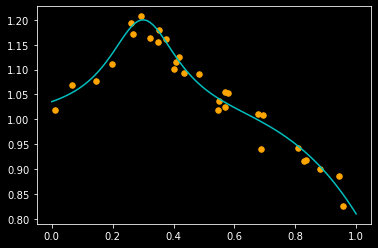

In [5]:
x, y = generate_n_datasets(1, 30)
plt.scatter(x.squeeze(), y.squeeze(), s=30, c='orange')
plt.plot(x_true, y_true, c='c', linewidth=1.5);

In [8]:
from copy import deepcopy
from tqdm import tqdm, trange

In [9]:
def calc_bias2_variance(model, datasets_X, datasets_y):
    """
    For every dataset in datesets_X take the model copy and fit it with target dataset_y
    and get predict data for x_true. Take mean over all predicts for get mean_predict,
    take bias as (y_true - mean_predict)**2 and variance
    """
    preds = []
    for X, y in tqdm(zip(datasets_X, datasets_y), total=len(datasets_X)):
        m = deepcopy(model)
        m.fit(X, y)
        preds.append(m.predict(x_true[:,np.newaxis]).squeeze())
    preds = np.array(preds)
    mean_pred = preds.mean(axis=0)
    bias2 = (y_true - mean_pred)**2
    variance = ((preds - mean_pred[np.newaxis,...])**2).mean(axis=0)

    return bias2, variance, preds

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

As you can see, we are using the `Pipeline` once again to both preprocess the feature space and fit the model at once.

In [19]:
MAX_POWER = 6
powers = np.arange(1, MAX_POWER+1)

bias2, variance, preds = [], [], []
for p in powers:
    model = Pipeline([
      ('poly', PolynomialFeatures(degree=p)),
      ('linear', LinearRegression())
    ])

    b2, v, p = calc_bias2_variance(model, *generate_n_datasets(1000, 20))
    bias2.append(b2)
    variance.append(v)
    preds.append(p)

bias2 = np.array(bias2)
variance = np.array(variance)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 818.41it/s]


6it [00:00,  6.09it/s]


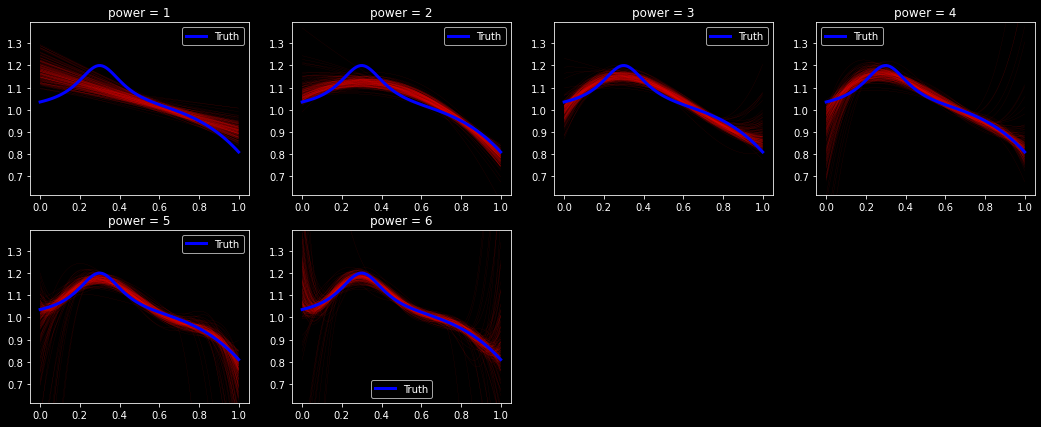

In [20]:
ncols = 4
nrows = int(np.ceil(len(powers) / ncols))

plt.figure(figsize=(18, 3.5 * nrows))

yrange = y_true.max() - y_true.min()

for i, (pred, pow) in tqdm(enumerate(zip(preds, powers), 1)):
    plt.subplot(nrows, ncols, i)
    for p in pred[np.random.choice(len(pred), size=200, replace=False)]:
        plt.plot(x_true, p, linewidth=0.05, c='r');
    plt.plot(x_true, y_true, linewidth=3, label='Truth', c='b')
    plt.ylim(y_true.min() - 0.5 * yrange, y_true.max() + 0.5 * yrange)
    plt.title('power = {}'.format(pow))
    plt.legend();

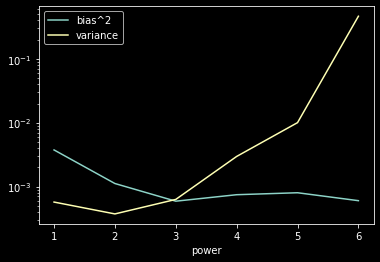

In [22]:
plt.plot(powers, bias2.mean(axis=1), label='bias^2')
plt.plot(powers, variance.mean(axis=1), label='variance')
plt.legend()
plt.yscale('log')
plt.xlabel('power');

### Extra: Runge's phenomenon
Speaking about polinomial features, going to higher degrees does not always improve accuracy. This effect was discovered by Carl David Tolmé Runge (1901) when exploring the behavior of errors when using polynomial interpolation to approximate certain functions. Refer to the [wikipedia page](https://en.wikipedia.org/wiki/Runge%27s_phenomenon) for more info.

To observe this phenomenon, let's run the exact same code as above, but with increased maximum power of the polinome.

In [23]:
MAX_POWER = 8
powers = np.arange(1, MAX_POWER+1)

bias2, variance, preds = [], [], []
for p in powers:
    model = Pipeline([
      ('poly', PolynomialFeatures(degree=p)),
      ('linear', LinearRegression())
    ])

    b2, v, p = calc_bias2_variance(model, *generate_n_datasets(1000, 20))
    bias2.append(b2)
    variance.append(v)
    preds.append(p)

bias2 = np.array(bias2)
variance = np.array(variance)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 839.57it/s]


8it [00:01,  6.04it/s]


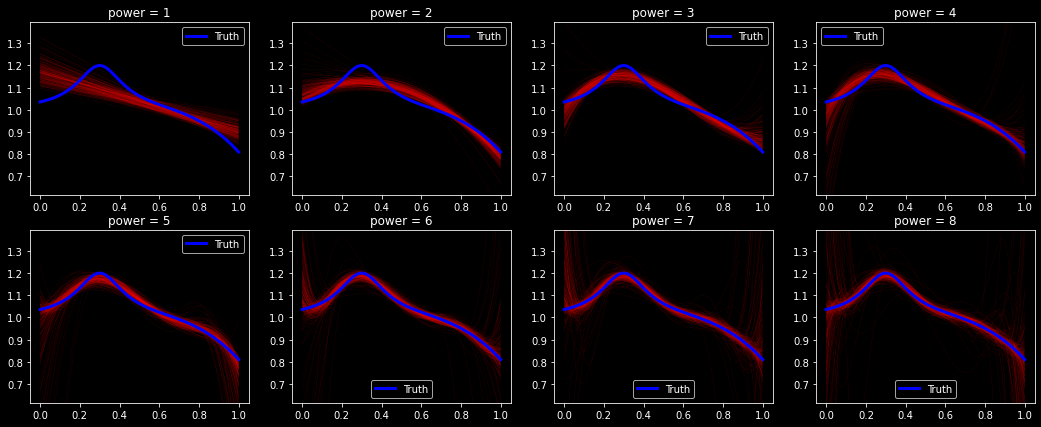

In [24]:
ncols = 4
nrows = int(np.ceil(len(powers) / ncols))

plt.figure(figsize=(18, 3.5 * nrows))

yrange = y_true.max() - y_true.min()

for i, (pred, pow) in tqdm(enumerate(zip(preds, powers), 1)):
    plt.subplot(nrows, ncols, i)
    for p in pred[np.random.choice(len(pred), size=200, replace=False)]:
        plt.plot(x_true, p, linewidth=0.05, c='r');
    plt.plot(x_true, y_true, linewidth=3, label='Truth', c='b')
    plt.ylim(y_true.min() - 0.5 * yrange, y_true.max() + 0.5 * yrange)
    plt.title('power = {}'.format(pow))
    plt.legend();

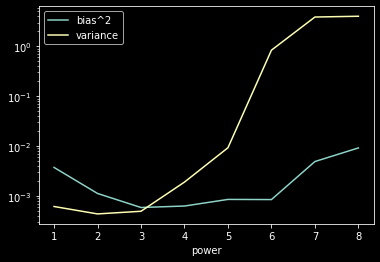

In [25]:
plt.plot(powers, bias2.mean(axis=1), label='bias^2')
plt.plot(powers, variance.mean(axis=1), label='variance')
plt.legend()
plt.yscale('log')
plt.xlabel('power');

As you can see, the bias is increasing after the power equal to 6 as well, but is is caused by the oscillations on the edges of the original function (we are trying to interpolate). Refer to the [wiki page](https://en.wikipedia.org/wiki/Runge%27s_phenomenon) for more info.